In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.interpolate import griddata

%matplotlib widget


In [8]:
fields = ['ph0', 'th0', 'fr0', 'vel0', 'ph1', 'th1', 'fr1', 'vel1', 'polarity']



def load_wind_files(directory):
    """
    Load wind files into a nested dictionary based on CR and data fields.

    Parameters:
    - directory: Path to the directory containing the files.

    Returns:
    A nested dictionary {CR: {field: data, ...}, ...}.
    """
    # Define the fields based on the order in the saved array
    big_dict = {}

    # Regex to extract details from filename
    pattern = re.compile(r"cr(\d+)_f(\d+)_op(\d+)_radial_wind_(\w+).npy")

    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            CR, nwant, n_open, method = match.groups()
            CR = int(CR)  # Convert CR to integer for use as a dictionary key

            # Ensure the CR key exists in the dictionary
            if CR not in big_dict:
                big_dict[CR] = {}

            file_path = os.path.join(directory, filename)
            data = np.load(file_path)

            # Assume data is saved in the order specified above
            for i, field in enumerate(fields):
                big_dict[CR][field] = data[i]

    return big_dict

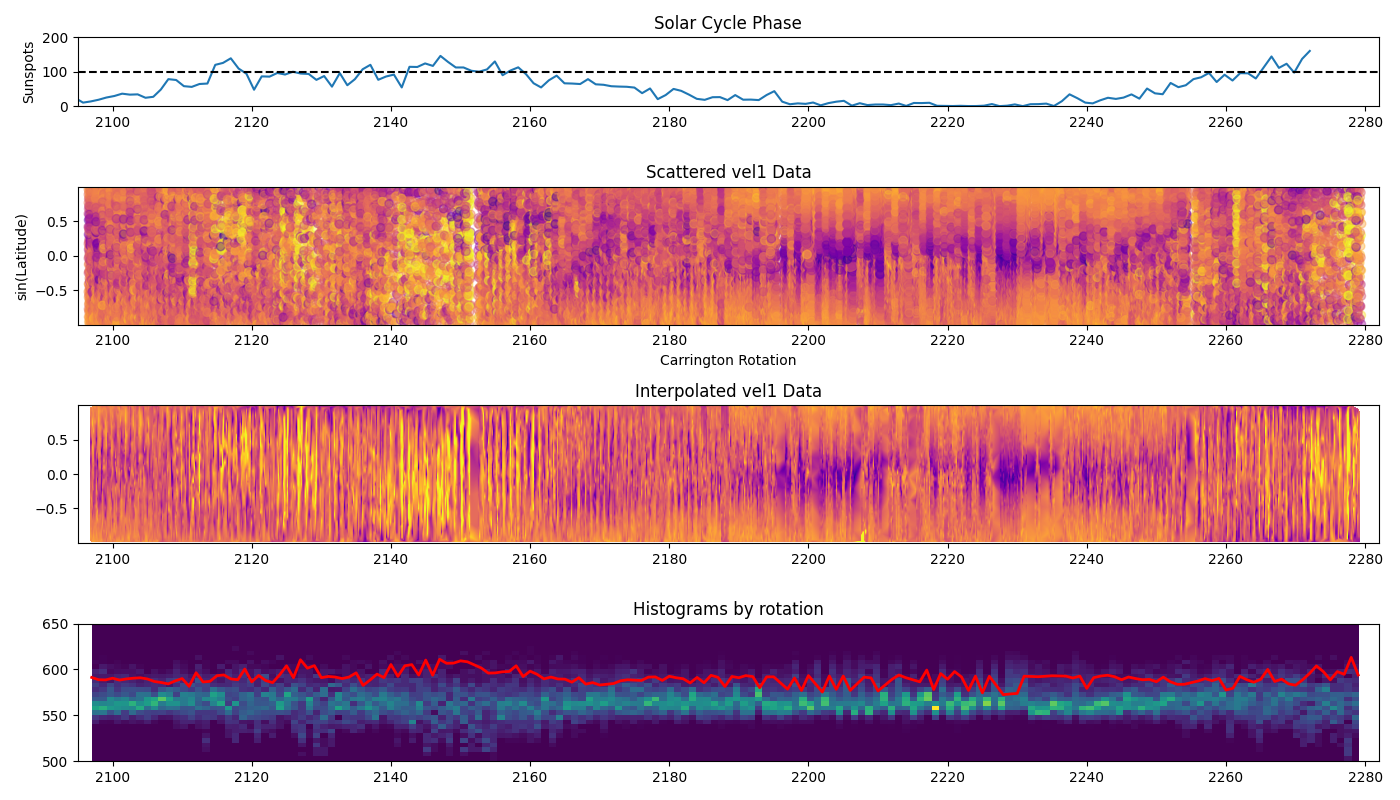

In [46]:
# def scatter1(big_dict, ax, CR=2135, offset=0,**kwargs):
#     # Accessing the data for CR 2135
#     phi1 = big_dict[CR]['ph1']
#     theta1 = big_dict[CR]['th1']
#     vel1_data = big_dict[CR]['vel1']
#     ax.scatter(phi1 + (offset * 2 * np.pi), theta1, c=vel1_data, vmin=450, vmax=700, **kwargs)

def scatter_all_keys(big_dict, **kwargs):

    for key in big_dict[2160].keys():
        scatter_all(big_dict, field=key, **kwargs)

def scatter_all(big_dict, field="vel1", **kwargs):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Create figure
    fig = plt.figure(figsize=(14, 8))

    # Define GridSpec: 4 rows, 1 column. Adjust the height ratios as needed.
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 2, 2, 2])

    # Create each subplot
    ax1 = fig.add_subplot(gs[0, 0])  # First row
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Second row
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax2, sharey=ax2)  # Third row
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax2)  # Third row
    axarray = [ax1, ax2, ax3, ax4]



    sunspotplot(axarray[0])




    # Prepare data for interpolation and plotting
    all_phi = []
    all_theta = []
    all_vel = []
    all_hist = []
    all_cr = []
    all_mean = []
    the_phi = "ph1" if "1" in field else "ph0"
    the_theta = "th1" if "1" in field else "th0"

    # Collect data from all CRs
    for ii, CR in enumerate(sorted(big_dict.keys())):

        phi1 = big_dict[CR][the_phi]/(2*np.pi) + ((CR-0.5))
        theta1 = big_dict[CR][the_theta]
        vel1_data = big_dict[CR][field]
        hist, bins = np.histogram(vel1_data, range=(450, 700), bins=30, density=True)

        all_phi.extend(phi1)
        all_theta.extend(theta1)
        all_vel.extend(vel1_data)

        all_hist.append(hist)
        all_mean.append(np.mean(vel1_data))
        all_cr.append(CR)


    # Convert lists to numpy arrays for griddata
    all_phi = np.array(all_phi)
    all_theta = np.array(all_theta)
    all_vel = np.array(all_vel)
    all_hist = np.array(all_hist).T
    all_cr = np.array(all_cr)

    axarray[3].imshow(all_hist, aspect='auto',
                      extent=(all_cr[0], all_cr[-1], 500, 650),
                      cmap='viridis', origin='lower')

    # histavg = np.average(all_vel, axis=0)
    axarray[3].plot(all_cr, all_mean, c='r', lw=2)

    # Scatter plot for each CR
    axarray[1].scatter(all_phi, all_theta, c=all_vel, **kwargs)

    # Create a regular grid where you want to interpolate data
    grid_phi, grid_theta = np.mgrid[min(all_phi):max(all_phi):1000j, min(all_theta):max(all_theta):1000j]

    # Interpolate scattered data to the regular grid
    grid_vel = griddata((all_phi, all_theta), all_vel, (grid_phi, grid_theta), method='linear')

    # Display the interpolated data as an image
    axarray[2].imshow(grid_vel.T, cmap="plasma", extent=(min(all_phi), max(all_phi), min(all_theta), max(all_theta)),
                      origin='lower', aspect='auto', vmin=kwargs.get("vmin", 500), vmax=kwargs.get("vmax", 650))
    axarray[3].set_title(f'Histograms by rotation')
    axarray[2].set_title(f'Interpolated {field} Data')
    axarray[1].set_title(f'Scattered {field} Data')
    axarray[1].set_xlabel('Carrington Rotation')
    axarray[1].set_ylabel('sin(Latitude)')
    plt.tight_layout()

    # for ax in [axarray]:
    #     ax.set_xlim((0, 2 * np.pi*ii))
    plt.show()

from datetime import datetime, timedelta


def decimal_years_to_datetimes(decimal_years):
    def convert(decimal_year):
        year = int(decimal_year)
        remainder = decimal_year - year
        start_of_year = datetime(year, 1, 1)
        # Check if it's a leap year
        if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
            days_in_year = 366
        else:
            days_in_year = 365
        days = remainder * days_in_year
        return start_of_year + timedelta(days=days)

    return [convert(year) for year in decimal_years]


def sunspotplot(carr_ax, cr=None):
# Plot the Sunspot Number
    carrington = np.loadtxt("/Users/cgilbert/vscode/fluxons/fluxon-mhd/fluxpipe/fluxpipe/plotting/SN_m_tot_V2.0.txt").T
    ## https://sidc.be/SILSO/datafiles#total ##
    import sunpy.coordinates
    date = carrington[2]
    sunspots = carrington[3]
    datetimes = decimal_years_to_datetimes(date)
    CR = sunpy.coordinates.sun.carrington_rotation_number(datetimes)

    if cr is not None:
        this_date = sunpy.coordinates.sun.carrington_rotation_time(cr)
        carr_ax.axvline(this_date.decimalyear, ls=":", c='k', zorder=1000000)

    # fig, ax = plt.subplots()
    carr_ax.plot(CR, sunspots, label="Sunspots")
    # carr_ax.set_xlabel("Year")
    carr_ax.set_ylabel("Sunspots")
    carr_ax.set_title("Solar Cycle Phase")
    carr_ax.set_xlim(2095, 2282)
    carr_ax.axhline(100, c='k', ls="--")
    # set the major tick formatter to display integers
    from matplotlib.ticker import MaxNLocator
    carr_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    carr_ax.set_ylim(0, 200)

# Example usage
directory_path = '/Users/cgilbert/vscode/fluxons/fluxon-data/batches/sequential/data/wind'  # Change this to your directory's path
big_dict = load_wind_files(directory_path)
scatter_all(big_dict, cmap='plasma', alpha = 0.4, vmin=500, vmax=650)


In [ ]:
def scatter_all(big_dict, field="vel1", ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 6))  # Fallback if no ax is provided

    # Plot data for each CR with an offset
    for ii, CR in enumerate(sorted(big_dict.keys())):
        phi_data = big_dict[CR]['ph1'] + (ii * 2 * np.pi)  # Offset for clarity
        theta_data = big_dict[CR]['th1']
        field_data = big_dict[CR][field]

        ax.scatter(phi_data, theta_data, c=field_data, alpha=0.5, **kwargs)

    ax.set_title(f'Scattered {field} Data Across CRs')
    ax.set_xlim((0, 2 * np.pi * len(big_dict.keys())))

def scatter_all_keys(big_dict, **kwargs):
    # Determine the number of fields for subplot dimensions
    first_CR = next(iter(big_dict))
    fields = [key for key in big_dict[first_CR].keys()]
    n_fields = len(fields)

    # Create a figure with a subplot for each field
    fig, axs = plt.subplots(n_fields, 1, figsize=(15, 6 * n_fields), sharex=True, sharey=True)

    if n_fields == 1:  # If there's only one field, axs is not a list but a single AxesSubplot object
        axs = [axs]

    # Iterate over fields and plot
    for ax, field in zip(axs, fields):
        scatter_all(big_dict, field=field, ax=ax, **kwargs)

    plt.tight_layout()
    plt.show()


In [53]:



import cv2
import os
from tqdm import tqdm

def images_to_video(input_dir, output_file, fps):
    # Get all PNG files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    image_files.sort()  # Ensure the files are in sorted order

    # Check if there are any PNG files in the directory
    if len(image_files) == 0:
        print("No PNG files found in the directory.")
        return

    # Determine the size of the first image
    sample_image = cv2.imread(os.path.join(input_dir, image_files[0]))
    height, width, _ = sample_image.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Iterate through each image and write it to the video
    for image_file in tqdm(image_files):
        image_path = os.path.join(input_dir, image_file)
        frame = cv2.imread(image_path)
        out.write(frame)

    # Release resources
    out.release()

    print(f"Video created successfully: {output_file}")

wind_path = '/Users/cgilbert/vscode/fluxons/fluxon-data/batches/sequential/imgs/windmap'  # Change this to your directory's path

images_to_video(wind_path, os.path.join(wind_path,"wind_video.mp4"), 10)


100%|██████████| 172/172 [00:11<00:00, 14.55it/s]

Video created successfully: /Users/cgilbert/vscode/fluxons/fluxon-data/batches/sequential/imgs/windmap/wind_video.mp4
